# 特征降维处理

In [1]:
########## 降维方法主要分两类：特征提取和特征选择
######## 特征提取： 基于空间变换的方式，通过数学方法将数据从高维映射到低维实现降维，比如主成分分析（PCA）方法，
### 但是这类方法得到的低维特征是其他特征融合而来，难以有一个具体的物理解释与含义，也就无法对实际工业操作过程提供指导。

######## 特征选择： 不改变原始特征空间，通过从原始空间中剔除无关和冗余的特征，选择出与数据挖掘任务高相关的特征子集，使学
### 习算法在约简后的数据上得到更精确、更易理解的模型，而且特征选择的计算复杂度相对特征抽取较低，实时性更好，
### 能更及时的对工业过程中的各种操作提供理论指导。



In [ ]:
## 混合式特征选择方法来进行数据降维

In [1]:
from sklearn import preprocessing
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
import xlrd
from random import randrange

plt.rcParams["font.sans-serif"] = "SimHei"  ## 设置中文显示
plt.rcParams['axes.unicode_minus']=False    # 默认是使用Unicode负号，设置正常显示字符，如正常显示负号

In [2]:
# 读取数据
df = pd.read_excel('D:\桌面\数据挖掘-汽油辛烷值损失模型优化\暑期模拟-3-2022-08-18\模拟练习-3 B题 汽油辛烷值建模\附件一 处理后的数据.xlsx')

In [15]:
# 查看数据行列数
df.shape

(325, 368)

In [3]:
# 数据归一化处理 （min-max标准化）
df_norm = (df - df.min()) / (df.max() - df.min())

In [4]:
# 特征降维： 低方差过滤法
# 特征方差小：某个特征大多样本的值比较相近
# 特征方差大：某个特征很多样本的值都有差别
# 低方差过滤法 指的是删除方差低于某些阈值的一些特征。

var = df_norm.var()
data = df_norm.columns
variable = []
num=[]
for i in range(0,len(var)):
    if var[data[i]]>=0.05:   # 将阈值设置为0.05
        num.append(i)
        variable.append(data[i])

In [5]:
# 查看列名
pd.set_option('display.max_rows', None) # 显示所有的行
display(data)

Index([           '硫含量,μg/g',              '辛烷值RON',      '饱和烃,v%（烷烃+环烷烃）',
                     '烯烃,v%',               '芳烃,v%',       '溴值\n,gBr/100g',
           '密度(20℃),\nkg/m³',          '硫含量,μg/g.1',            '辛烷值RON.1',
             'RON损失\n（不是变量）',
       ...
                     '再生器藏量',       '加氢裂化轻石脑油进装置流量',           '汽油产品去气分流量',
           '加氢裂化轻石脑油进装置累积流量',         '汽油产品去气分累积流量',   '8.0MPa氢气至循环氢压缩机入口',
       '8.0MPa氢气至循环氢压缩机入口.1',   '8.0MPa氢气至反吹氢压缩机出口', '8.0MPa氢气至反吹氢压缩机出口.1',
               'D101原料缓冲罐压力'],
      dtype='object', length=368)

In [6]:
# 查看通过低方差过滤法后得到的剩余特征数目
a=len(variable)
a

# 筛选特征根据低方差过滤法
# 根据题目要求建立降低辛烷值损失模型，因此辛烷值RON作为因变量
df2=df["辛烷值RON"]
for i in range(0,len(var)):
    if i in num:
        df1=df[df.columns[i]]
        df2= pd.concat([df2,df1],axis=1)

In [248]:
# # 根据特征的重要性筛选特征
# 随机森林计算各个特征的重要性
from sklearn.ensemble import RandomForestRegressor
# 先删去因变量辛烷值RON为了接下来的拟合
df2=df2.drop('辛烷值RON', axis=1)

# 模型拟合
model = RandomForestRegressor(random_state=1, max_depth=10)
df2=pd.get_dummies(df2)
df2.columns = list(map(str, df2.columns))
model.fit(df2,df["辛烷值RON"])

RandomForestRegressor(max_depth=10, random_state=1)

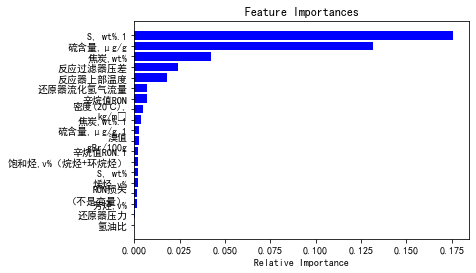

In [250]:
# 拟合模型后，根据特征的重要性绘制成图：
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances[0:19])  # 选取重要性前20的特征
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [251]:
# 可以直接使用SelectFromModel根据权重的重要性选择特征
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(model)
Fit = feature.fit_transform(df2,df["辛烷值RON"])


In [256]:
# 筛选特征根据随机森林特征重要性排序
df3=df["辛烷值RON"]
for i in range(0,len(num)):
    if i in indices:
        df1=df[df.columns[i]]
        df3= pd.concat([df3,df1],axis=1)

In [259]:
# # 根据特征的相关性筛选特征
#  高相关滤波
# 如果两个变量之间是高度相关的，这意味着它们具有相似的趋势并且可能携带类似的信息。
# 同理，这类变量的存在会降低某些模型的性能（例如线性和逻辑回归模型）。
# 为了解决这个问题，我们可以计算独立数值变量之间的相关性。如果相关系数超过某个阈值，就删除其中一个变量。

# 先删除因变量辛烷值RON
df3=df3.drop('辛烷值RON', axis=1)
df_corr=df3.corr()
df_corr.where(df_corr<0.6,inplace=True)
df_corr

,"硫含量,μg/g","饱和烃,v%（烷烃+环烷烃）","烯烃,v%","芳烃,v%","溴值\n,gBr/100g","密度(20℃),\nkg/m³","硫含量,μg/g.1",辛烷值RON.1,RON损失\n（不是变量）,"焦炭,wt%","S, wt%","焦炭,wt%.1","S, wt%.1",氢油比,反应过滤器压差,还原器压力,还原器流化氢气流量,反应器上部温度
"硫含量,μg/g",NaN,-0.439445,0.393012,0.035479,-0.134371,0.191346,0.232752,0.495207,-0.159506,0.198535,0.026314,0.287492,0.044039,-0.256936,-0.380525,-0.120377,0.263956,0.135653
"饱和烃,v%（烷烃+环烷烃）",-0.439445,NaN,-0.927412,0.005614,0.074326,-0.137826,-0.326567,-0.465400,0.225079,-0.194133,0.210229,-0.192574,0.161257,0.455738,0.272268,-0.011737,-0.598214,0.088427
"烯烃,v%",0.393012,-0.927412,NaN,-0.379168,0.030349,-0.039253,0.369578,0.395357,-0.183523,0.195710,-0.213384,0.213712,-0.169728,-0.444075,-0.189375,0.041432,0.586378,-0.058926
"芳烃,v%",0.035479,0.005614,-0.379168,NaN,-0.263256,0.445307,-0.179623,0.093182,-0.065047,-0.042174,0.049402,-0.094535,0.053936,0.058436,-0.168552,-0.080851,-0.086673,-0.058398
"溴值\n,gBr/100g",-0.134371,0.074326,0.030349,-0.263256,NaN,-0.234731,0.080511,-0.128533,0.115584,0.062738,0.159434,0.051425,0.053925,0.075871,0.400493,0.166654,-0.008241,0.051631
"密度(20℃),\nkg/m³",0.191346,-0.137826,-0.039253,0.445307,-0.234731,NaN,-0.003829,0.261409,-0.105899,-0.113899,0.032891,-0.123247,0.020604,-0.022668,-0.126839,-0.062728,-0.112085,-0.148907
"硫含量,μg/g.1",0.232752,-0.326567,0.369578,-0.179623,0.080511,-0.003829,NaN,0.208359,-0.243184,0.182498,0.014174,0.157955,0.034508,-0.186216,-0.179001,-0.038136,0.405246,-0.113343
辛烷值RON.1,0.495207,-0.465400,0.395357,0.093182,-0.128533,0.261409,0.208359,NaN,-0.265499,0.041976,-0.024737,0.040082,-0.029240,-0.231098,-0.119419,0.061447,0.159464,0.051922
RON损失\n（不是变量）,-0.159506,0.225079,-0.183523,-0.065047,0.115584,-0.105899,-0.243184,-0.265499,NaN,-0.160486,0.009819,-0.059165,-0.058711,0.290977,0.259532,0.018413,-0.253982,0.127631
"焦炭,wt%",0.198535,-0.194133,0.195710,-0.042174,0.062738,-0.113899,0.182498,0.041976,-0.160486,NaN,0.557547,NaN,0.568273,-0.351009,-0.386914,-0.380646,0.505654,0.168386


In [260]:
## 从上述结果可以看出，焦炭,wt%.1和S, wt%.1这两个特征与其他特征相关性将强，将其删去
df3=df3.drop('焦炭,wt%.1', axis=1)
df3=df3.drop('S, wt%.1', axis=1)


In [261]:
# 重新查看特征之间相关性
df_corr=df3.corr()
df_corr.where(df_corr<0.6,inplace=True)
df_corr

,"硫含量,μg/g","饱和烃,v%（烷烃+环烷烃）","烯烃,v%","芳烃,v%","溴值\n,gBr/100g","密度(20℃),\nkg/m³","硫含量,μg/g.1",辛烷值RON.1,RON损失\n（不是变量）,"焦炭,wt%","S, wt%",氢油比,反应过滤器压差,还原器压力,还原器流化氢气流量,反应器上部温度
"硫含量,μg/g",NaN,-0.439445,0.393012,0.035479,-0.134371,0.191346,0.232752,0.495207,-0.159506,0.198535,0.026314,-0.256936,-0.380525,-0.120377,0.263956,0.135653
"饱和烃,v%（烷烃+环烷烃）",-0.439445,NaN,-0.927412,0.005614,0.074326,-0.137826,-0.326567,-0.465400,0.225079,-0.194133,0.210229,0.455738,0.272268,-0.011737,-0.598214,0.088427
"烯烃,v%",0.393012,-0.927412,NaN,-0.379168,0.030349,-0.039253,0.369578,0.395357,-0.183523,0.195710,-0.213384,-0.444075,-0.189375,0.041432,0.586378,-0.058926
"芳烃,v%",0.035479,0.005614,-0.379168,NaN,-0.263256,0.445307,-0.179623,0.093182,-0.065047,-0.042174,0.049402,0.058436,-0.168552,-0.080851,-0.086673,-0.058398
"溴值\n,gBr/100g",-0.134371,0.074326,0.030349,-0.263256,NaN,-0.234731,0.080511,-0.128533,0.115584,0.062738,0.159434,0.075871,0.400493,0.166654,-0.008241,0.051631
"密度(20℃),\nkg/m³",0.191346,-0.137826,-0.039253,0.445307,-0.234731,NaN,-0.003829,0.261409,-0.105899,-0.113899,0.032891,-0.022668,-0.126839,-0.062728,-0.112085,-0.148907
"硫含量,μg/g.1",0.232752,-0.326567,0.369578,-0.179623,0.080511,-0.003829,NaN,0.208359,-0.243184,0.182498,0.014174,-0.186216,-0.179001,-0.038136,0.405246,-0.113343
辛烷值RON.1,0.495207,-0.465400,0.395357,0.093182,-0.128533,0.261409,0.208359,NaN,-0.265499,0.041976,-0.024737,-0.231098,-0.119419,0.061447,0.159464,0.051922
RON损失\n（不是变量）,-0.159506,0.225079,-0.183523,-0.065047,0.115584,-0.105899,-0.243184,-0.265499,NaN,-0.160486,0.009819,0.290977,0.259532,0.018413,-0.253982,0.127631
"焦炭,wt%",0.198535,-0.194133,0.195710,-0.042174,0.062738,-0.113899,0.182498,0.041976,-0.160486,NaN,0.557547,-0.351009,-0.386914,-0.380646,0.505654,0.168386


In [270]:
# 将最后筛选的数据存入csv
df3 = pd.concat([df["辛烷值RON"]],df3,axis=1)
df3.to_csv('D:\桌面\降维后特征.xlsx',index=False,encoding="utf-8_sig") 

In [ ]:
# 更多特征筛选方法：https://blog.csdn.net/u010608296/article/details/120555077?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522166104873316781647521249%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=166104873316781647521249&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~pc_rank_34-2-120555077-null-null.142^v42^pc_rank_34_ecpm25,185^v2^control&utm_term=pandas%20dataframe%20%E4%BD%8E%E6%96%B9%E5%B7%AE%E6%BB%A4%E6%B3%A2&spm=1018.2226.3001.4187
# 最后筛选出16个特征 （不包括因变量辛烷值RON）

In [ ]:
#### 在筛选重要性较低的特征时，除了利用随机森林对特征重要性进行评估，我们还可以利用Relif方法

In [7]:
# 先删去因变量辛烷值RON为了接下来的拟合
df2=df2.drop('辛烷值RON', axis=1)

In [148]:
### Relief过滤式特征选择算法  https://blog.csdn.net/comli_cn/article/details/103377597

In [147]:
# 定义归一化函数
def normalize(features):
    (n_samples, n_features) = np.shape(features)
    print("shape=", n_samples, n_features)
    fe_max = []
    fe_min = []
    n_deno = []
    new_features = np.zeros((n_samples, n_features))
    print("new_features=", new_features)
    for i in range(0, n_features):
        max_index = np.argmax(features[:, i])
        min_index = np.argmin(features[:, i])
        fe_max.append(features[max_index, i])  # 计算每一个特征的最大值
        fe_min.append(features[min_index, i])  # 计算每一个特征的最小值
    n_deno = np.asarray(fe_max) - np.asarray(fe_min)  # 求出归一化的分母
    for j in range(0, n_features):
        for k in range(0, n_samples):
            new_features[k, j] = (features[k, j]-fe_min[j]) / n_deno[j]  # 归一化
    return new_features


In [146]:
# 计算出一个距离矩阵
def sap_distance(features):
    (n_samples, n_features) = np.shape(features)
    distance = np.zeros((n_samples, n_samples))
    for i in range(0, n_samples):
        for j in range(0, n_samples):
            diff_distance = features[i]-features[j]
            if i == j:
                distance[i, j] = 9999
            else:
                distance[i, j] = euclid_distance(diff_distance)  # 使用欧几里德距离定义样本之间的距离
    print("距离：",distance)
    return distance

In [145]:
def euclid_distance(diff_distance):
    counter = np.power(diff_distance, 2)
    counter = np.sum(counter)
    counter = np.sqrt(counter)
    return counter

In [144]:
# 从和R同类的样本中寻找最近邻样本H，称为NearHit，从和R不同类的样本中寻找最近邻样本M，称为NearMiss，然后根据以下规则更新每个特征的权重:
# 如果R和NearHit在某个特征上的距离小于R和NearMiss上的距离，则说明该特征对区分同类和不同类的最近邻是有益的，则增加该特征的权重；
# 反之，如果R和NearHit在某个特征的距离大于R和NearMiss上的距离，说明该特征对区分同类和不同类的最近邻起负面作用，则降低该特征的权重。
def search_near(sample_distance, labels, randnum, feartures):
    [n_samples, n_features] = np.shape(features)
    nearhit_list = []
    nearmiss_list = []
    hit_index = []
    miss_index = []
    for i in range(0, n_features):
        if labels[i] == labels[randnum]:
            nearhit_list.append(sample_distance[i, randnum])  # 将距离放在一个列表里面
            hit_index.append(i)                                 # 将样本标号放在另一个列表里面
        else:
            nearmiss_list.append(sample_distance[i, randnum])
            miss_index.append(i)
    nearhit_dis_index = nearhit_list.index(min(nearhit_list))   # 算出猜中近邻
    nearhit_index = hit_index[nearhit_dis_index]                # 将猜中近邻的样本标号赋给nearhit_index

    nearmiss_dis_index = nearmiss_list.index(min(nearmiss_list))
    nearmiss_index = miss_index[nearmiss_dis_index]


    nearhit = feartures[nearhit_index]
    nearmiss = feartures[nearmiss_index]

    return nearhit, nearmiss, nearhit_index, nearmiss_index

In [143]:
def relevant_feature(nearhit_index, nearmiss_index, new_features, randnum):
    diff_hit = abs(new_features[nearhit_index]-new_features[randnum])
    diff_miss = abs(new_features[nearmiss_index]-new_features[randnum])
    delta = -np.power(diff_hit, 2)+np.power(diff_miss, 2)
    return delta

In [153]:
def relief(features, labels, times):   # 传入特征矩阵，标签矩阵和随机选择的次数，因为有可能样本有很多，所以我们随机选择若干个样本来计算;这里的矩阵都是np.array
    (n_samples, n_features) = np.shape(features)
    delta = []
    delta_features = []
    delta_index = []
    sample_distance = sap_distance(features)  # 计算每两个样本之间的距离
    new_features = normalize(features)        # 对特征值归一化
    # 下面开始计算相关统计量，并对各个特征的相关统计量进行比较，最后返回各个特征值相关统计量从高到低的排名
    
#     # 这是将随机选取的样本代入计算出来的delta
#     for i in range(0, times):
#         randnum = randrange(0, n_samples, 1)        # 生成一个随机数
#         one_sample = features[randnum]        # 随机选择一个样本
#         (nearhit, nearmiss, nearhit_index, nearmiss_index) = search_near(sample_distance, labels, randnum, features)  # 找出猜中近邻和猜错近邻,nearhit为猜中近邻样本的行向量
#         delta.append(relevant_feature(nearhit_index, nearmiss_index, new_features, randnum))  # 计算相关统计量矩阵
#     delta = np.asarray(delta)
#     for j in range(0, n_features):
#         delta_features.append(np.sum(delta[:, j]))
#     midd = list(set(delta_features))
#     midd.sort(reverse=True)
#     for p in midd:
#         for q in range(0, len(delta_features)):
#             if delta_features[q] == p:
#                 delta_index.append(q)
#     return delta_index

    # 这是将所有样本都带入计算的delta
    for i in range(0, n_features):
        (nearhit, nearmiss, nearhit_index, nearmiss_index) = search_near(sample_distance,labels,i,features)  # 找出猜中近邻和猜错近邻,nearhit为猜中近邻样本的行向量
        delta.append(relevant_feature(nearhit_index, nearmiss_index, new_features, i))  # 计算相关统计量矩阵
    delta = np.asarray(delta)
    for j in range(0, n_features):
        delta_features.append(np.sum(delta[:, j]))
    midd = list(set(delta_features))
    midd.sort(reverse=True)    #对列表进行逆序排序, 值大的数排在前面
    for p in midd:
        for q in range(0, len(delta_features)):
            if delta_features[q] == p:
                delta_index.append(q)
    return delta_index
## 特征的权重越大，表示该特征的分类能力越强，反之，表示该特征分类能力越弱。

In [154]:
labels = df2.columns.values
times=5
features=df2.values
features_importance = relief(features, labels, times)
print("特征重要性排序：", features_importance)

距离： [[9.99900000e+03 8.50410246e+05 1.19208261e+06 ... 7.36371373e+07
  7.37711059e+07 7.39070387e+07]
 [8.50410246e+05 9.99900000e+03 3.42068952e+05 ... 7.34399581e+07
  7.35695185e+07 7.37010858e+07]
 [1.19208261e+06 3.42068952e+05 9.99900000e+03 ... 7.33622458e+07
  7.34900466e+07 7.36198710e+07]
 ...
 [7.36371373e+07 7.34399581e+07 7.33622458e+07 ... 9.99900000e+03
  5.02042272e+05 1.00254639e+06]
 [7.37711059e+07 7.35695185e+07 7.34900466e+07 ... 5.02042272e+05
  9.99900000e+03 5.00508748e+05]
 [7.39070387e+07 7.37010858e+07 7.36198710e+07 ... 1.00254639e+06
  5.00508748e+05 9.99900000e+03]]
shape= 325 142
new_features= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
特征重要性排序： [68, 107, 83, 73, 82, 100, 101, 15, 13, 76, 74, 99, 44, 98, 11, 64, 105, 8, 54, 115, 125, 57, 116, 66, 94, 89, 48, 114, 97, 46, 119, 5, 75, 77, 124, 51, 6, 10, 85, 1, 120, 106, 0, 118, 63, 70, 109, 17, 

In [ ]:
## Relief算法缺点：（1）当样本数据量较小时，其基于统计相关性的计算过程容易收到噪声信号的影响，得到的特征权值会有误差。
##（2）没有充分考虑特征之间的联系，因此选择的特征集合存在冗余